<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-brief-introduction-to-Rasterio-and-Pysheds" data-toc-modified-id="A-brief-introduction-to-Rasterio-and-Pysheds-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A brief introduction to Rasterio and Pysheds</a></span><ul class="toc-item"><li><span><a href="#opening-the-raster" data-toc-modified-id="opening-the-raster-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>opening the raster</a></span></li><li><span><a href="#Lets-look-at-the-data:" data-toc-modified-id="Lets-look-at-the-data:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Lets look at the data:</a></span></li><li><span><a href="#Raster-cookie-cutter-(mask)" data-toc-modified-id="Raster-cookie-cutter-(mask)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Raster cookie cutter (mask)</a></span></li></ul></li></ul></div>

# A brief introduction to Rasterio and Pysheds

## opening the raster

In [1]:
import rasterio as rio
import numpy as np
from rasterio.plot import show
from pathlib import Path
import fiona
import matplotlib.pyplot as plt
%matplotlib notebook

In [129]:
# path to the dataset from https://hydrosheds.cr.usgs.gov/datadownload.php
# !! Note this is deprecated, this file is no longer in the repo
data_dir = Path(r'dem_data\mystery_dem\dem_adf_files')
dem_path = data_dir/'w001001.adf'


### Let's see what we have downloaded

In [130]:
dem = rio.open('01_proj_vic_dem.tif')

In [131]:
# what have we created in python?
dem

<open DatasetReader name='dem_data\mystery_dem\dem_adf_files\w001001.adf' mode='r'>

Kind of like opening a text file, we have created a view into this raster dataset, but need to ask rio what things we actually need from it

In [132]:
# lets get the coordinat reference system
dem.crs

CRS.from_epsg(4326)

In [133]:
dem.bounds

BoundingBox(left=112.0, bottom=-56.0, right=179.99999999999727, top=-10.00000000000184)

In [6]:
# lets see the units
dem.units

(None,)

In [134]:
#dem resolution
dem.res

(0.0041666666666665, 0.0041666666666665)

#### Quick geographic challenge:
- if the resolution is in decimal degrees, then what is the resolution (cell size) in seconds of latitude and longitude? 
- How much is that in a real unit (metres)

In [ ]:
#type your answer here:

## Lets look at the data:

<IPython.core.display.Javascript object>


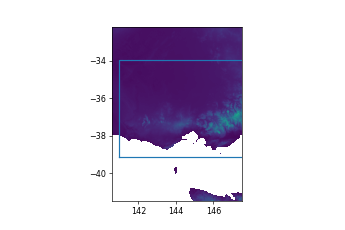

In [135]:
#lets have a quick look at it to see what we have
fig , ax = plt.subplots()
show(dem, ax=ax)

### Thats probably more data than we need to extract a watershed, so lets maybe clip out a useful subset
our options for doing this are:
- Slicing like a numpy array
- or geographically subset things (better!)

In [136]:
import fiona

with fiona.open('victoria_box.geojson', 'r') as vector:
    vic_shapes = [feature["geometry"] for feature in vector]

In [43]:
vic_shapes

[{'type': 'Polygon',
  'coordinates': [[(140.9693, -39.1591),
    (150.0334, -39.1591),
    (150.0334, -33.9972),
    (140.9693, -33.9972),
    (140.9693, -39.1591)]]}]

In [137]:

box_coords = np.array(vic_shapes[0]['coordinates'][0])

<IPython.core.display.Javascript object>


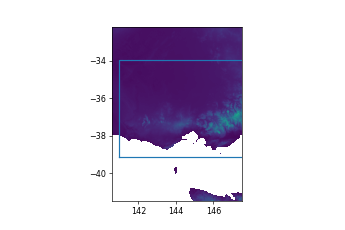

In [138]:
ax.plot(box_coords[:,0], box_coords[:,1])
fig
# plt.plot(vic_shapes['coordinates'])

## Raster cookie cutter (mask)

We will clip our raster to the vector file we have here

In [139]:
import rasterio.mask

vic_dem, vic_transform = rasterio.mask.mask(dem, vic_shapes)


type(vic_dem)

numpy.ndarray

In [55]:
vic_transform

Affine(0.0041666666666665, 0.0, 112.0,
       0.0, -0.0041666666666665, -10.00000000000184)

In [140]:
## Note we need to grab everything attached to the original DEM so its not just 
out_meta = dem.meta
out_meta.update({"driver": "GTiff",
                 "height": vic_dem.shape[1],
                 "width": vic_dem.shape[2],
                 "transform": vic_transform})


In [141]:
cropped_dem_file = "vic_dem.tif"
with rasterio.open(cropped_dem_file, "w", **out_meta) as dest:
    dest.write(vic_dem)
    dest.close()
    


### Lets get this into a more useful projected coordinate system

- Go from latitude pixels
- to square m pixels (Universal transverse Mercator (UTM))

In [142]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [143]:
# need a destination coordinate reference system this is utm zone 55s (good for eastern Australia)
dst_crs = 'EPSG:32755'

repr_dem_path = '01_proj_' + cropped_dem_file


#Reopen the file
vic_dem = rio.open(cropped_dem_file)
    
# creating the transform
transform, width, height = calculate_default_transform(vic_dem.crs, 
                                                       dst_crs, 
                                                       vic_dem.width, 
                                                       vic_dem.height,
                                                       *vic_dem.bounds)

In [144]:
transform, width, height

(Affine(411.95314993775065, 0.0, -3582350.7080885074,
        0.0, -411.95314993775065, 8894570.502164438),
 19185,
 13757)

In [145]:
# need build the metadata
kwargs = vic_dem.meta.copy()
kwargs.update({
    'crs': dst_crs,
    'transform': transform,
    'width': width,
    'height': height
})

In [146]:
with rio.open(repr_dem_path, 'w', **kwargs) as dst:
    for i in range(1, vic_dem.count + 1):
        reproject(
            source=rio.band(vic_dem, i),
            destination=rio.band(dst, i),
            src_transform=vic_dem.transform,
            src_crs=vic_dem.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear)

In [147]:
vic_dem.close()

In [148]:
#lets check what we have done
reprojected_vic = rio.open(repr_dem_path)
reprojected_vic.res

(411.95314993775065, 411.95314993775065)

In [ ]:
show(reprojected_vic)

### Now that we have the data in the way we want it , we will use Pysheds to calculate a DEM

In [2]:
fairfield_boathouse = (325102.35, 5816011.93) #easting, and northing

In [4]:
from pysheds.grid import Grid
import seaborn as sns

In [5]:
grid = Grid.from_raster('01_proj_vic_dem.tif', data_name='dem', nodata = -32768.0)

In [6]:
grid.fill_depressions('dem', out_name='flooded_dem')
    
# Resolve flats in DEM
grid.resolve_flats('flooded_dem', out_name='inflated_dem')
    
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)


In [8]:
# Delineate the catchment
# if you want to do multiple catchments

# poitns [(4,5)]

grid.catchment(data='dir', x=fairfield_boathouse[0], y=fairfield_boathouse[1], dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to('catch')
np.sum(grid.view('catch'))*412*412/(10**6)

Raster(1960.253088)

In [9]:
grid.catch.bbox

(-3582350.7080885074, 3226919.0653208653, 4321382.426617177, 8894570.502164438)

In [10]:
bbox = grid.catch.bbox
extent = (bbox[0]-1000, bbox[2]-1000, bbox[1]+1000, bbox[3]+1000)



<IPython.core.display.Javascript object>


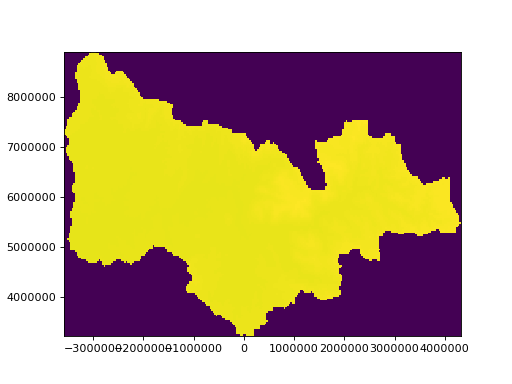

In [11]:
%matplotlib notebook

# grid.view('dem')[grid.view('dem') <0] = np.nan
fig2, ax2 = plt.subplots()

ax2.imshow(grid.view('dem'), extent=extent, cmap='viridis', zorder=1)
ax2.scatter(fairfield_boathouse[0], fairfield_boathouse[1])

Help on function read_raster in module pysheds.grid:

read_raster(self, data, data_name, band=1, window=None, window_crs=None, metadata={}, **kwargs)
    Reads data from a raster file into a named attribute of Grid
    (name of attribute determined by keyword 'data_name').
    
    Parameters
    ----------
    data : str
           File name or path.
    data_name : str
                Name of dataset. Will determine the name of the attribute
                representing the gridded data.
    band : int
           The band number to read if multiband.
    window : tuple
             If using windowed reading, specify window (xmin, ymin, xmax, ymax).
    window_crs : pyproj.Proj instance
                 Coordinate reference system of window. If None, assume it's in raster's crs.
    metadata : dict
               Other attributes describing dataset, such as direction
               mapping for flow direction files. e.g.:
               metadata={'dirmap' : (64, 128, 1, 2, 4, 8, 16, 32

In [122]:
help(rio.open)

Help on function open in module rasterio:

open(fp, mode='r', driver=None, width=None, height=None, count=None, crs=None, transform=None, dtype=None, nodata=None, sharing=False, **kwargs)
    Open a dataset for reading or writing.
    
    The dataset may be located in a local file, in a resource located by
    a URL, or contained within a stream of bytes.
    
    In read ('r') or read/write ('r+') mode, no keyword arguments are
    required: these attributes are supplied by the opened dataset.
    
    In write ('w' or 'w+') mode, the driver, width, height, count, and dtype
    keywords are strictly required.
    
    Parameters
    ----------
    fp : str, file object or pathlib.Path object
        A filename or URL, a file object opened in binary ('rb') mode,
        or a Path object.
    mode : str, optional
        'r' (read, the default), 'r+' (read/write), 'w' (write), or
        'w+' (write/read).
    driver : str, optional
        A short format driver name (e.g. "GTiff" or "